# Article Category Recommendation Using RNN
**Author: Hafiz Fahrurrozi**

Text classification is crucial along with growing size of articles on the web. Sometimes the would-be-reader are having difficulties finding relevant article by category. To help writers and readers alike, we create a simple category recommendation model using Recurrent Neural Network.

The dataset used for the training is taken from kaggle.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, gensim
from yake import KeywordExtractor
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics, model_selection, preprocessing

Load cython for faster word vectorization

In [2]:
%load_ext Cython

Set tensorflow to use memory growth

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Download stop words and wordnet

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(nltk.corpus.stopwords.words('english'))
lemma = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading
Load the data from csv

In [12]:
raw = pd.read_csv('news_category_dataset_v2.csv')
raw.head()

,category,headline,short_description,text
0,crime,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,"DENTON, Texas â€• Amanda Painter sat at the ki..."
1,entertainment,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,The 2018 FIFA World Cup starts June 14 in Russ...
2,entertainment,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,Love actually turned to matrimony for Hugh Gra...
3,entertainment,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,Rep. Adam Schiff (D-Calif.) and fellow Democra...
4,entertainment,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",Actress Julianna Margulies unleashed her funny...


Distribution of category:

In [13]:
raw.category.value_counts()

politics         33616
entertainment    28966
lifestyle        25136
wellness         17828
fashion          15393
other            14966
opinion          11972
travel            9927
business          9657
world news        8419
culinary          8345
sports            4884
tech              4801
environment       4090
crime             3618
economy           2690
religion          2556
science           2215
education         2200
sport              712
Name: category, dtype: int64

## Data Cleaning
Fill the null values with space and merge headline, short description, and text columns

In [14]:
raw = raw.fillna(' ')
raw['content'] = raw.headline + ' ' + raw.short_description + ' ' + raw.text
cln = raw[['category','content']]

## Data Preprocessing

In [15]:
x = cln.content.str.lower()
y = cln.category.str.lower()

cat = len(y.unique())

enc = preprocessing.LabelBinarizer()
yt = enc.fit_transform(y)

### Keyword extraction

In [10]:
%%time
invec = 10
kwe = KeywordExtractor(n=1, top=invec, stopwords=stop_words)
z = []
for j in range(len(x)):
    keywords = kwe.extract_keywords(text=x[j])
    z.append([x for x,y in keywords])

Wall time: 19min 31s


### Word vectorization

In [11]:
%%time
outvec = 150
# learn word vectors
w2v_model = gensim.models.Word2Vec(sentences=z, vector_size=outvec, min_count=2, workers=4)
w2v_model.save('m2p2.wordvectors')

# keep keyvector, delete model
wv = w2v_model.wv
del(w2v_model)

# number of words library
print('Number of words :',len(wv))

Number of words : 44054
Wall time: 6.61 s


### Words to numbers

In [12]:
tkn = keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(z)

xt = tkn.texts_to_sequences(z)

win = tkn.word_index
for word, num in win.items():
    print(f"{word} -> {num}")
    if num == 5:
        break

trump -> 1
new -> 2
photos -> 3
one -> 4
people -> 5


### Word weights

In [14]:
vocab_size = len(win) + 1

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, outvec))
    for word, i in vocab.items():
        if word not in model:
            weight_matrix[i] = 0
        else:
            weight_matrix[i] = model[word]
    return weight_matrix

emvec = get_weight_matrix(wv, win)

## Model definition

In [154]:
tf.keras.backend.clear_session()
mod1 = keras.models.Sequential()
mod1.add(keras.layers.Embedding(vocab_size, output_dim=outvec, weights=[emvec], input_length=invec, trainable=False))
mod1.add(keras.layers.LSTM(units=64, return_sequences=True))
mod1.add(keras.layers.Dropout(0.2))
mod1.add(keras.layers.LSTM(units=64))
mod1.add(keras.layers.Dropout(0.2))
mod1.add(keras.layers.Dense(cat, activation='softmax'))
mod1.compile(optimizer=keras.optimizers.Adam(0.005), loss='categorical_crossentropy', metrics=[keras.metrics.Precision()])

cb = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 150)           12660600  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            55040     
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 41)                2665      
Total params: 12,751,329
Trainable params: 90,729
Non-trainable params: 12,660,600
_______________________________________

## Model training

In [155]:
%%time
hist1 = mod1.fit(xt,yt,batch_size=6000,epochs=500,callbacks=[cb],verbose=0)

Wall time: 44min 25s


## Model Evaluation

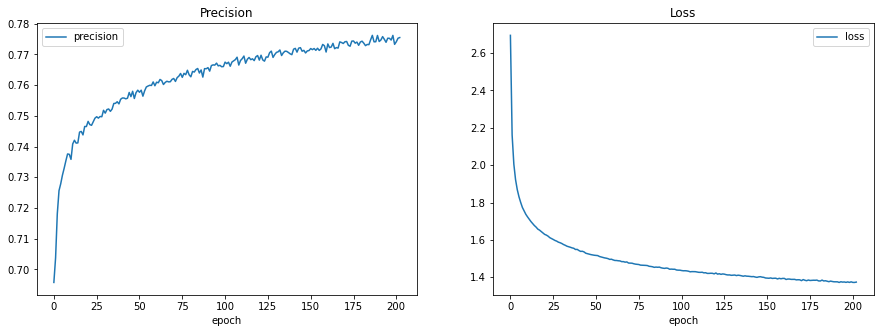

In [159]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Precision')
plt.plot(hist1.history['precision'], label='precision')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(hist1.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

Save the model

In [158]:
mod1.save('test_1.h5')

## Model Inference

In [25]:
infer = "ARTIFICIAL INTELLIGENCE BASED OCEANOGRAPHY AI Oceanography : The fourth industrial revolution comes in the form of oceanographic science Artificial Intelligence : In 2020 the term is practically inescapable. From self-driving cars to AI-enabled smartphones; The explosion in the functioning and trading of AI games, expert game-playing computers, machine learning techniques for an endless variety of tasks. Led by companies such as Amazon, Google, Apple and Samsung, companies around the world are revolutionizing their businesses, with recent developments in deep learning (large neural network) algorithms and a steady decline in computing power. Scientists in many disciplines are at the forefront of finding new ways to exploit powerful model-detection and statistical reasoning enabled by modern AI. In Life Sciences, AI provides insights into the human genome, predicts cancer development, and accelerates drug discovery at an unprecedented place. In the earth sciences, AI improves atmospheric and environmental time series by representing missing data and integrating conflicting observations, correcting bias, and building better models of attendance than previously possible. Do you want to where Artificial Intelligence is used in our daily life,apart from oceanography, thenâ€¦. The long-standing and uninterrupted geological research question of when and when the next major earthquake will occur, for the first time, maybe soluble using neural networks. The promise of machine learning s"
infer = infer.lower()
keywords = kwe.extract_keywords(text=infer)
k = [[x for x,y in keywords]]
print('Keywords from text:',k)
kin = tkn.texts_to_sequences(k)
kou = keras.preprocessing.sequence.pad_sequences(kin, maxlen=invec)
kpr = mod1.predict(kou)
print(sorted(zip(kpr[0]*100,enc.classes_), reverse=True)[:3])

Keywords from text: [['learning', 'artificial', 'intelligence', 'oceanography', 'smartphones', 'games', 'expert', 'computers', 'tasks', 'based']]
[(45.349392, 'healthy living'), (25.16079, 'wellness'), (8.848903, 'parenting')]
